# Agentic Patterns (Simple Walkthrough)

This notebook is a **guided demo** of an “agentic” assistant that:
1) Plans a few steps  
2) Calls safe, pre-approved tools (no external APIs)  
3) Checks its own work and repairs small issues  
4) Produces a compact **QBR slide pack** with citations

> **You can run everything offline.** Change a couple of settings and re-run the “Run Demo” cell.

### Visualizations
- A simple **flow diagram** of the control loop.
- A **summary table** of produced slides.
- A **line chart** of metrics for one account.
- A **timeline chart** of the run (step durations).
- A clean **audit log** you can review like a black box recorder.

### Quick scenario controls
- `REGION`: which accounts to include (east/west)
- `STEP_BUDGET`: max number of actions allowed.
- `ROLE`: permissions profile (analyst | manager)

In [1]:
# Scenario controls
REGION = "west"        # "east" or "west"
FAILURE_RATE = 0.15    # 0.0 (easy) ... 0.35 (harder)
STEP_BUDGET = 60
ROLE = "analyst"       # "analyst" or "manager"

import uuid
RUN_ID = f"run-{uuid.uuid4().hex[:8]}"
print({"RUN_ID": RUN_ID, "REGION": REGION, "FAILURE_RATE": FAILURE_RATE, "STEP_BUDGET": STEP_BUDGET, "ROLE": ROLE})

{'RUN_ID': 'run-ad71efdb', 'REGION': 'west', 'FAILURE_RATE': 0.15, 'STEP_BUDGET': 60, 'ROLE': 'analyst'}


## Workflow
Observe → Plan → Authorize → Act (Tool) → Verify → Repair? → Stop

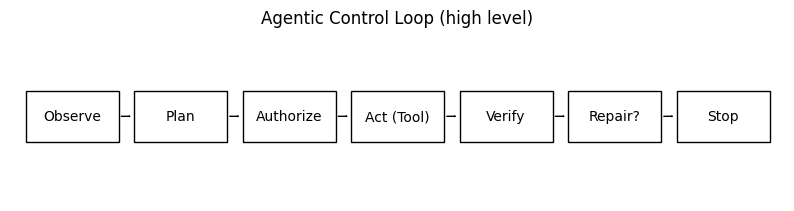

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

plt.figure(figsize=(10, 2.2))
ax = plt.gca(); ax.axis("off")

stages = ["Observe", "Plan", "Authorize", "Act (Tool)", "Verify", "Repair?", "Stop"]
x = 0.02
for s in stages:
    ax.add_patch(Rectangle((x, 0.35), 0.12, 0.3, fill=False))
    ax.text(x+0.06, 0.5, s, ha="center", va="center")
    x += 0.14
x = 0.14
for _ in range(len(stages)-1):
    ax.add_patch(FancyArrowPatch((x, 0.5), (x+0.02, 0.5), arrowstyle='->'))
    x += 0.14

plt.title("Agentic Control Loop (high level)")
plt.show()

## Setup: demo data, tools, and control loop

Below we set up small, in-notebook “virtual services” for CRM, billing, product usage, and tickets.  
The assistant will call these tools, verify results, and produce slides.

In [3]:
import random, time, uuid, json
from dataclasses import dataclass, field
from typing import Any, Dict, List

random.seed(7)

ACCOUNTS = [
    {"account_id": "A100", "name": "Acme Health", "owner": "Riley", "region": "west"},
    {"account_id": "A200", "name": "Beacon Retail", "owner": "Zhu", "region": "west"},
    {"account_id": "A300", "name": "Cobalt Finance", "owner": "Sam", "region": "east"},
    {"account_id": "A400", "name": "Delta Studios", "owner": "Riley", "region": "west"},
]

def gen_series(seed, base=10000):
    random.seed(seed); s = []; v = base + random.randint(-500, 500)
    for _ in range(90):
        v += random.randint(-120, 120); v = max(0, v); s.append(v)
    return s

BILLING = {
    "A100": {"mrr_series": gen_series(101, 12000)},
    "A200": {"mrr_series": gen_series(202, 8000)},
    "A300": {"mrr_series": gen_series(303, 15000)},
    "A400": {"mrr_series": gen_series(404, 6000)},
}

USAGE = {
    "A100": {"daily_active": gen_series(11, 300)},
    "A200": {"daily_active": gen_series(22, 150)},
    "A300": {"daily_active": gen_series(33, 500)},
    "A400": {"daily_active": gen_series(44, 120)},
}

TICKETS = [
    {"account_id": "A100", "severity": "high", "title": "SLA breach risk", "open": True},
    {"account_id": "A200", "severity": "medium", "title": "Billing confusion", "open": True},
    {"account_id": "A200", "severity": "high", "title": "Integration failing", "open": True},
    {"account_id": "A300", "severity": "low", "title": "Feature request", "open": False},
    {"account_id": "A400", "severity": "high", "title": "Renewal at risk", "open": True},
]

@dataclass
class ToolSpec:
    name: str
    inputs: Dict[str, Any]
    outputs: Dict[str, Any]
    permissions: List[str]
    side_effects: bool = False
    version: str = "v1"

@dataclass
class ToolResult:
    status: str
    data: Dict[str, Any] = field(default_factory=dict)
    errors: List[str] = field(default_factory=list)
    evidence: List[Dict[str, str]] = field(default_factory=list)
    idempotency_key: str = ""
    version: str = "v1"

class ToolRegistry:
    def __init__(self): self.tools = {}; self.specs = {}
    def register(self, spec: ToolSpec, fn): self.tools[spec.name] = fn; self.specs[spec.name] = spec
    def list(self): return list(self.specs.keys())

REGISTRY = ToolRegistry()
AUDIT_LOG: List[Dict[str, Any]] = []

def _now_ms():
    return int(time.time() * 1000)

def validate_inputs(spec: ToolSpec, args: Dict[str, Any]) -> List[str]:
    errs = []
    for k, rule in spec.inputs.items():
        if rule.get("required", False) and k not in args:
            errs.append(f"missing required field '{k}'")
    return errs

class FailureInjector:
    def __init__(self, rate=0.1, use_latency=True): self.rate=rate; self.use_latency=use_latency
    def maybe_fail(self):
        if self.use_latency: time.sleep(random.uniform(0.01, 0.06))
        r = random.random()
        if r < self.rate * 0.25: raise TimeoutError("simulated timeout")
        if r < self.rate * 0.5: raise ValueError("simulated 404 or bad id")
        if r < self.rate * 0.75: return {"stale": True}
        return {}

FAIL = FailureInjector(rate=0.15, use_latency=True)

def log_step(tool, args, result, start_ms, meta=None):
    AUDIT_LOG.append({
        "ts": _now_ms(), "tool": tool, "args": args,
        "result": result.__dict__ if hasattr(result,"__dict__") else result,
        "duration_ms": _now_ms() - start_ms, "meta": meta or {},
    })

def mk_env(status="ok", data=None, errors=None, evidence=None, idem=None, version="v1"):
    import uuid
    return ToolResult(status=status, data=data or {}, errors=errors or [], evidence=evidence or [], idempotency_key=idem or str(uuid.uuid4()), version=version)

# Tools
crm_spec = ToolSpec("crm.search", {"region": {"required": True}}, {"accounts": {}}, ["analyst","manager"])
def crm_search(region:str)->ToolResult:
    start=_now_ms()
    try:
        mark = FAIL.maybe_fail()
        accounts = [a for a in ACCOUNTS if a["region"]==region]
        if mark.get("stale"): accounts = accounts[:-1] or accounts
        env = mk_env(data={"accounts": accounts}); log_step("crm.search", {"region": region}, env, start); return env
    except Exception as e:
        env = mk_env(status="error", errors=[str(e)]); log_step("crm.search", {"region": region}, env, start); return env
REGISTRY.register(crm_spec, crm_search)

billing_spec = ToolSpec("billing.mrr", {"account_id":{"required":True}}, {"current_mrr":{}, "mrr_series":{}}, ["analyst","manager"])
def billing_mrr(account_id:str)->ToolResult:
    start=_now_ms()
    try:
        mark = FAIL.maybe_fail(); series = BILLING[account_id]["mrr_series"]
        if mark.get("stale"): series = series[:-5] + [series[-6]]*5
        env = mk_env(data={"current_mrr": series[-1], "mrr_series": series}, evidence=[{"type":"source","url":f"billing://mrr/{account_id}"}])
        log_step("billing.mrr", {"account_id": account_id}, env, start); return env
    except Exception as e:
        env = mk_env(status="error", errors=[str(e)]); log_step("billing.mrr", {"account_id": account_id}, env, start); return env
REGISTRY.register(billing_spec, billing_mrr)

usage_spec = ToolSpec("product.usage", {"account_id":{"required":True}}, {"daily_active":{}, "usage_trend":{}}, ["analyst","manager"])
def product_usage(account_id:str)->ToolResult:
    start=_now_ms()
    try:
        mark = FAIL.maybe_fail(); series = USAGE[account_id]["daily_active"]
        if mark.get("stale"): series = series[:-7] + [sum(series[-14:-7])//7]*7
        trend = (series[-1] - series[-14]) / max(1, series[-14])
        env = mk_env(data={"daily_active": series, "usage_trend": trend}, evidence=[{"type":"source","url":f"usage://dau/{account_id}"}])
        log_step("product.usage", {"account_id": account_id}, env, start); return env
    except Exception as e:
        env = mk_env(status="error", errors=[str(e)]); log_step("product.usage", {"account_id": account_id}, env, start); return env
REGISTRY.register(usage_spec, product_usage)

tickets_spec = ToolSpec("tickets.risks", {"account_id":{"required":True}}, {"top_risks":{}}, ["analyst","manager"])
def tickets_risks(account_id:str)->ToolResult:
    start=_now_ms()
    try:
        _ = FAIL.maybe_fail()
        risks = [t for t in TICKETS if t["account_id"]==account_id and t["open"]]
        risks = [{"severity": t["severity"], "title": t["title"]} for t in risks]
        env = mk_env(data={"top_risks": risks}, evidence=[{"type":"source","url":f"tickets://open/{account_id}"}])
        log_step("tickets.risks", {"account_id": account_id}, env, start); return env
    except Exception as e:
        env = mk_env(status="error", errors=[str(e)]); log_step("tickets.risks", {"account_id": account_id}, env, start); return env
REGISTRY.register(tickets_spec, tickets_risks)

slides_spec = ToolSpec("slides.make", {"deck_spec":{"required":True}}, {"slide_id":{}}, ["analyst","manager"], side_effects=True)
SLIDE_STORE = {}
def slides_make(deck_spec:dict)->ToolResult:
    start=_now_ms()
    try:
        idem = deck_spec.get("idem", str(uuid.uuid4()))
        if idem in SLIDE_STORE:
            env = mk_env(status="ok", data={"slide_id": SLIDE_STORE[idem]}, idem=idem)
        else:
            _ = FAIL.maybe_fail()
            slide_id = f"S{len(SLIDE_STORE)+1:03d}"; SLIDE_STORE[idem] = slide_id
            env = mk_env(status="ok", data={"slide_id": slide_id}, idem=idem, evidence=[{"type":"artifact","url":f"slides://{slide_id}"}])
        log_step("slides.make", {"deck_spec": {"account_id": deck_spec.get("account_id","?"), "idem": idem}}, env, start); return env
    except Exception as e:
        env = mk_env(status="error", errors=[str(e)]); log_step("slides.make", {"deck_spec": {"account_id": deck_spec.get("account_id","?")}}, env, start); return env
REGISTRY.register(slides_spec, slides_make)

class Controller:
    def __init__(self, role="analyst", step_budget=50):
        self.role=role; self.step_budget=step_budget; self.steps=0
    def authorize(self, tool_name, args):
        spec = REGISTRY.specs[tool_name]
        if self.role not in spec.permissions: return False, ["permission denied"]
        errs = validate_inputs(spec, args); return (len(errs)==0), errs
    def budget_ok(self):
        self.steps += 1
        return self.steps <= self.step_budget

class Critic:
    REQ = ["account_id","account_name","owner","current_mrr","trend_90d","top_risks","next_actions","citations"]
    def verify(self, slide):
        errs=[]; 
        for k in self.REQ:
            if k not in slide: errs.append(f"missing field: {k}")
        if slide.get("current_mrr",0) < 0: errs.append("current_mrr negative")
        if not slide.get("citations"): errs.append("missing citations")
        return errs

class Planner:
    def __init__(self, region): self.region=region
    def plan_accounts(self): return [{"tool":"crm.search","args":{"region": self.region}}]
    def plan_slide(self, account):
        aid = account["account_id"]
        return [
            {"tool":"billing.mrr","args":{"account_id": aid}},
            {"tool":"product.usage","args":{"account_id": aid}},
            {"tool":"tickets.risks","args":{"account_id": aid}},
            {"tool":"slides.make","args":{"deck_spec":{"account_id": aid, "idem": f"{aid}-qbr"}}},
        ]

def run_agent(goal_region, role, step_budget, failure_rate):
    global AUDIT_LOG; AUDIT_LOG = []
    FAIL.rate = failure_rate
    ctrl = Controller(role=role, step_budget=step_budget)
    planr = Planner(goal_region); critic = Critic()
    results = {"slides": [], "needs_review": [], "metrics": {"tool_calls":0, "errors":0}}

    # discover accounts
    for step in planr.plan_accounts():
        if not ctrl.budget_ok(): break
        ok, errs = ctrl.authorize(step["tool"], step["args"]); 
        if not ok: results["metrics"]["errors"]+=1; continue
        res = REGISTRY.tools[step["tool"]](**step["args"]); results["metrics"]["tool_calls"]+=1
        accts = res.data.get("accounts", []) if res.status=="ok" else []

    for acct in accts:
        if not ctrl.budget_ok(): break
        steps = planr.plan_slide(acct)
        collected={"mrr":None,"series":None,"risks":[],"evidence":[]}
        for s in steps[:-1]:
            if not ctrl.budget_ok(): break
            ok, errs = ctrl.authorize(s["tool"], s["args"])
            if not ok: results["metrics"]["errors"]+=1; break
            res = REGISTRY.tools[s["tool"]](**s["args"]); results["metrics"]["tool_calls"]+=1
            if res.status!="ok": 
                old=FAIL.rate; FAIL.rate=max(0.0, old-0.1)
                res = REGISTRY.tools[s["tool"]](**s["args"]); FAIL.rate=old
            if res.status!="ok": results["metrics"]["errors"]+=1; break
            if s["tool"]=="billing.mrr": collected["mrr"]=res.data["current_mrr"]; collected["series"]=res.data["mrr_series"]
            if s["tool"]=="tickets.risks": collected["risks"]=res.data["top_risks"]
            collected["evidence"].extend(res.evidence)

        slide={
            "account_id": acct["account_id"], "account_name": acct["name"], "owner": acct["owner"],
            "current_mrr": collected["mrr"] or 0,
            "trend_90d": round((collected["series"][-1]-collected["series"][0]) / max(1, collected["series"][0]), 3) if collected["series"] else 0.0,
            "top_risks": collected["risks"][:5],
            "next_actions": ["follow_up_with_owner","schedule_qbr"],
            "citations": collected["evidence"],
        }
        errs = critic.verify(slide)
        if errs:
            results["needs_review"].append({"account_id": acct["account_id"], "issues": errs, "slide": slide})
        else:
            make_args = steps[-1]["args"]; make_args["deck_spec"].update(slide)
            ok, _ = ctrl.authorize("slides.make", make_args)
            if ok and ctrl.budget_ok():
                res = REGISTRY.tools["slides.make"](**make_args); results["metrics"]["tool_calls"]+=1
                slide["slide_id"] = res.data.get("slide_id","?")
            results["slides"].append(slide)
    return results, AUDIT_LOG

## Run Demo
**The agentic assistant will:**
1. **look up accounts** for your region.  
2. For each account, **fetch facts** (revenue trend, usage, open risks).  
3. **assemble a slide** in a fixed format (like a form), with **citations**.  
4. **check the result** against rules (required fields, ranges, citations).  
5. something fail, it **retry once** or **flag for review**, instead of guessing.  

In [4]:
results, trace = run_agent(REGION, ROLE, STEP_BUDGET, FAILURE_RATE)

print("Slides produced:", len(results["slides"]))
print("Needs review:", len(results["needs_review"]))
print("Tool calls:", results["metrics"]["tool_calls"], "Errors:", results["metrics"]["errors"])

import json, pandas as pd

slides_df = pd.DataFrame(results["slides"])
needs_df = pd.DataFrame(results["needs_review"])

display(slides_df.head())
display(needs_df.head())

Slides produced: 3
Needs review: 0
Tool calls: 13 Errors: 0


,account_id,account_name,owner,current_mrr,trend_90d,top_risks,next_actions,citations,slide_id
0,A100,Acme Health,Riley,11185,-0.083,"[{'severity': 'high', 'title': 'SLA breach ris...","[follow_up_with_owner, schedule_qbr]","[{'type': 'source', 'url': 'billing://mrr/A100...",S001
1,A200,Beacon Retail,Zhu,8286,0.003,"[{'severity': 'medium', 'title': 'Billing conf...","[follow_up_with_owner, schedule_qbr]","[{'type': 'source', 'url': 'billing://mrr/A200...",S002
2,A400,Delta Studios,Riley,5010,-0.122,"[{'severity': 'high', 'title': 'Renewal at ris...","[follow_up_with_owner, schedule_qbr]","[{'type': 'source', 'url': 'billing://mrr/A400...",S003


""


## Visuals

### Account snapshot (metrics over time)

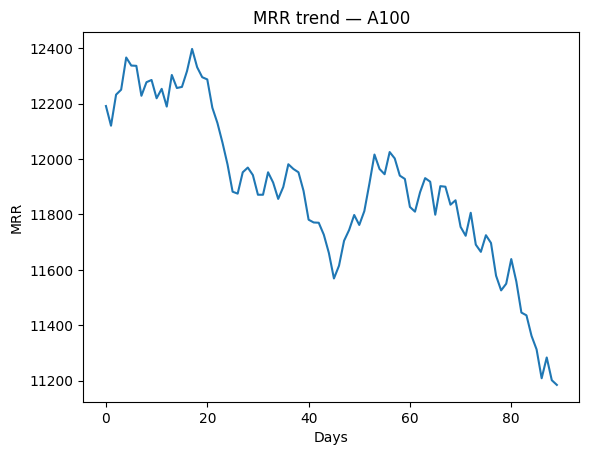

In [5]:
import matplotlib.pyplot as plt

if len(results["slides"]) > 0:
    aid = results["slides"][0]["account_id"]
    series = [v for v in [BILLING[aid]["mrr_series"]]]
    plt.figure()
    plt.plot(series[0])
    plt.title(f"MRR trend — {aid}")
    plt.xlabel("Days")
    plt.ylabel("MRR")
    plt.show()
else:
    print("No slides to visualize.")

### Timeline of this run (step durations)

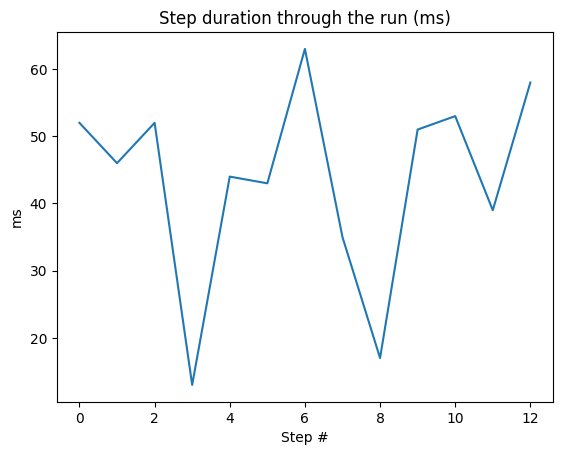

In [6]:
dur = [row.get("duration_ms",0) for row in trace]
if dur:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(dur)
    plt.title("Step duration through the run (ms)")
    plt.xlabel("Step #")
    plt.ylabel("ms")
    plt.show()
else:
    print("No steps recorded.")

## Glossary (quick)
- **Agentic**: the assistant plans steps, uses tools, and adapts based on results.  
- **Tool**: a safe, pre-approved action (e.g., fetch revenue, draft a slide).  
- **Schema**: the fixed shape of inputs/outputs; it makes automation reliable.  
- **Citation**: a link back to where a value came from (source of truth).  
- **Audit log**: a step-by-step record of actions for review and improvement.